# JPR-201712_serum

### Analysis performed by Phil Wilmarth

### 20190428

This is [publicly available data](https://www.ebi.ac.uk/pride/archive/projects/PXD005486) from this publication:

> D’Angelo, G., Chaerkady, R., Yu, W., Hizal, D.B., Hess, S., Zhao, W., Lekstrom, K., Guo, X., White, W.I., Roskos, L. and Bowen, M.A., 2017. Statistical models for the analysis of isobaric tags multiplexed quantitative proteomics. Journal of proteome research, 16(9), pp.3124-3136.

This notebook looks at the data from a commercial serum systemic lupus erythematosus (SLE) data set with 10-plex TMT labeling analyzed on a Q-Exactive platform. An Agilent MARS-6 immuno-depletion column was used to remove albumin, IgG, IgA, transferrin, haptoglobin, and antitrypsin. Proteins were digested with trypsin and labeled according to manufacturer's protocol. There were 10 normal controls and 10 SLE cases. Samples were split between plexes in a balanced fashion where the first 5 channels were controls and the second 5 channels were the SLE cases. There were no common reference channels.

Each plex was separated into 24 fractions (not clear by what technique) followed by 90-min RP gradients on a Dionex Ultimate 3000 RS system. The Q-Exactive used a top-15 method with MS1 resolution of 70K and MS2 resolution of 35K.

---

- [Overview](#overview) 
- [R libraries and data loading](#load) 
- [IRS check](#irs_check) 
- [Load edgeR data structures](#load_edger) 
- [Normalization](#norm_check) 
- [Differential expression testing](#DE)
- [Top-10 DE plots](#topN)
 
---

## Overview <a name="overview"></a>

Peptides and proteins were identified using Comet and the PAW pipeline. A wider 1.25 Da parent ion mass tolerance was used, TMT labels and alkylated cysteine were specified as static modifications, oxidation of methionine was specified as a variable modification, (semi) trypsin enzyme specificity was used, and a canonical UniProt reference human protein database was used. Fragment ion tolerance was set for high resolution MS2: 0.02 Da, offset of 0.0. Confident peptide identifications were obtained using accurate mass conditional score histograms, the target/decoy method, and the protein inference used basic parsimony principles. 

The PAW pipeline was used to infer proteins, perform homologous protein grouping, establish peptide uniqueness to the inferred proteins, and sum unique PSM reporter ions into protein intensity totals. The criteria for protein detection was at least two fully-tryptic, distinct peptide sequences per protein per plex. Semi-tryptic peptides contributed to PSMs for the proteins meeting the criteria. 

Results tables were filtered to remove common contaminants (and the 6 MARS proteins), and the protein intensity tables were saved as tab-delimited text files for reading by the scripts below. Normalizations and statistical testing were performed using the Bioconductor package edgeR as detailed in the steps below. A [Jupyter notebook](https://jupyter.org) with an R kernel was used to execute R commands and visualize the results. 

> Thompson, A., Schäfer, J., Kuhn, K., Kienle, S., Schwarz, J., Schmidt, G., Neumann, T. and Hamon, C., 2003. Tandem mass tags: a novel quantification strategy for comparative analysis of complex protein mixtures by MS/MS. Analytical chemistry, 75(8), pp.1895-1904.

> Wilmarth, P.A., Riviere, M.A. and David, L.L., 2009. Techniques for accurate protein identification in shotgun proteomic studies of human, mouse, bovine, and chicken lenses. Journal of ocular biology, diseases, and informatics, 2(4), pp.223-234.

> Gentleman, R.C., Carey, V.J., Bates, D.M., Bolstad, B., Dettling, M., Dudoit, S., Ellis, B., Gautier, L., Ge, Y., Gentry, J. and Hornik, K., 2004. Bioconductor: open software development for computational biology and bioinformatics. Genome biology, 5(10), p.R80.

> Robinson, M.D., McCarthy, D.J. and Smyth, G.K., 2010. edgeR: a Bioconductor package for differential expression analysis of digital gene expression data. Bioinformatics, 26(1), pp.139-140.


## Load the necessary libraries here <a name="load"></a>

In [1]:
# library imports
library(tidyverse)
library(scales)
library(limma)
library(edgeR)
library(psych)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor


Attaching package: ‘psych’

The following objects are masked from ‘package:scales’:

    alpha, rescale

The following objects are masked from ‘package:ggplot2’:

    %+%, alpha



## Load the IRS-normalized TMT intensity data
The pandas Python script that does the IRS normalization arranges the tab-delimited table so that importing into R is straightforward. The dplyr package from the tidyverse (https://r4ds.had.co.nz/) makes it easy to separate the data by biological condition, and to look at the data before and after the Internal Reference Scaling (IRS) normalization procedure. We can do some sanity checks with the pooled internal standard channels. We know that those should be highly similar within each TMT experiment and that IRS should make them also very similar between TMT experiments.

---
### Use average of all channels for scaling factors

This study design did not have any common reference channels, but the study design was balanced with 5 control and 5 SLE samples in each plex. The N3 sample in the first plex did not label well. It was about 1/8 of the average total signal of the other channels. That channel was excluded before the IRS script was run. We can use the average intensities across all channels in each plex as a mock reference channel. 

---

In [2]:
# get the default plot width and height
width <- options()$repr.plot.width
height <- options()$repr.plot.height

In [3]:
# load the IRS-normalized data and check the table
data_import <- read_tsv("ave_labeled_grouped_protein_summary_TMT_9_IRS_normalized.txt", guess_max = 596)

# the "Filter" column flags contams and decoys
# the "Missing" column flags proteins without reporter ion intensities (full sets missing)
# the prepped table from pandas is sorted so these are the upper rows
data_all <- filter(data_import, is.na(Filter), is.na(Missing))

# save gene names for edgeR so we can double check that results line up
accessions <- data_all$Accession

# see how many rows in the table
nrow(data_all)

Parsed with column specification:
cols(
  .default = col_double(),
  Accession = col_character(),
  Identical = col_character(),
  Similar = col_character(),
  OtherLoci = col_character(),
  Filter = col_character(),
  Missing = col_character(),
  Coverage = col_character(),
  SeqLength = col_character(),
  MW = col_character(),
  Description = col_character()
)
See spec(...) for full column specifications.


[1] 467

## Serum proteome has wide dynamic range

The MARS-6 depletion was quite good with the sum of the depleted proteins accounting for only about 1% of the total signal. There were 24 fractions per plex (details on separation were missing from the publication), so a reasonably deep proteome might be expected. We end up with 467 total proteins identified by at least two peptides. This really is the way experiments turn out for serum/plasma. It is really, really hard to get down to the putative biomarker levels.

The publication used tryptic enzyme cleavage. Secreted proteins always have signal peptides, so the N-terminal region of the protein never matches the database sequence. There are also other protein processing cleavages for protein activation in some cases. There can also be many endogenous proteases in bio fluids. Semi-tryptic cleavage (or even non-specific cleavage) should always be used for saliva, serum, and other biological fluids. 

I did both fully tryptic and semi-tryptic searches with Comet. There was a **14% gain** in number of filtered PSMs with the semi-tryptic search. This was about half of what I would have guessed based on my previous experience, but it is still pretty significant.

Protein database choice and search parameters really should be considered as variable in most proteomics analyses. This is particularly important when systems, sample preps, and organisms have not been encountered previously. Proteomics is not a one-size-fits all situation. This can be annoying at times; however, it does keep life interesting.

In [4]:
# we want to get the SL normed columns, and subsetted by condition
sl_all <- data_all %>%
  select(starts_with("SLNorm"))
sl_N <- sl_all %>% select(contains("_N"))
sl_SLE <- sl_all %>% select(contains("_SLE"))

# and the IRS normed columns by condition
irs_all <- data_all %>%
  select(starts_with("IRSNorm"))
irs_N <- irs_all %>% select(contains("_N"))
irs_SLE <- irs_all %>% select(contains("_SLE"))

# and collect the pooled channels before and after IRS
sl_pool <- sl_all %>% select(contains("pool"))
irs_pool <- irs_all %>% select(contains("pool"))

head(sl_N)

SLNorm_N1_1,SLNorm_N2_1,SLNorm_N4_1,SLNorm_N5_1,SLNorm_N1_2,SLNorm_N2_2,SLNorm_N3_2,SLNorm_N4_2,SLNorm_N5_2
4367122573,1815253094,2326738148,3159000701,2946648208,3562098847,2583022239,3949242962,4067489079
1964981086,3164118223,2524822909,2545045255,2391235927,2261576790,3069261841,2194111328,2023820487
399015388,644896222,486819857,498966209,474282483,429491247,585956443,305187796,393419619
274200898,585881482,477194190,509266722,494727463,426317477,524112715,324216478,307542905
338198145,360927971,399667938,330043171,512853303,305749592,526925179,415155466,504681097
231554918,352490856,412016767,244924393,358930915,388213032,336540720,682187652,247715128


## Check the pooled standard channels before and after IRS <a name="irs_check"></a>

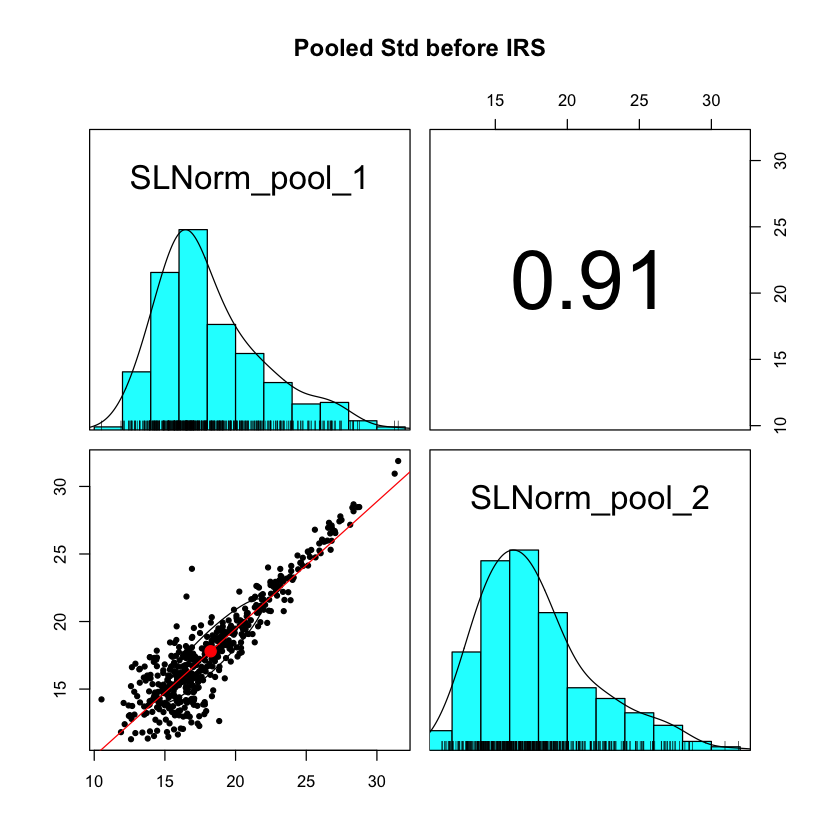

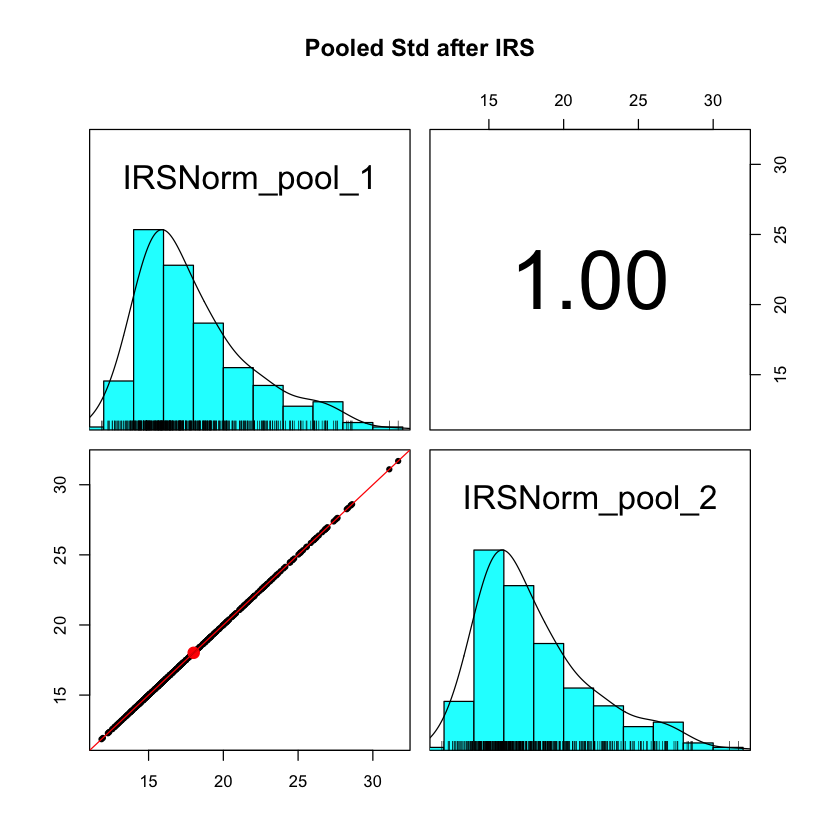

In [5]:
# multi-panel scatter plot grids from the psych package
pairs.panels(log2(sl_pool), lm = TRUE, main = "Pooled Std before IRS")
pairs.panels(log2(irs_pool), lm = TRUE, main = "Pooled Std after IRS")

## Scatter plot between plexes is poor before IRS

The random sampling of MS2 scans is why the before IRS scatter plot is awful. We are using the average of all channels in each plex for a mock pooled channel in the IRS method. We can use the mock standard channel to check the IRS correction. 

## We can also compare samples by condition before and after IRS

Since we have a lot of samples, we will randomly look at a few.

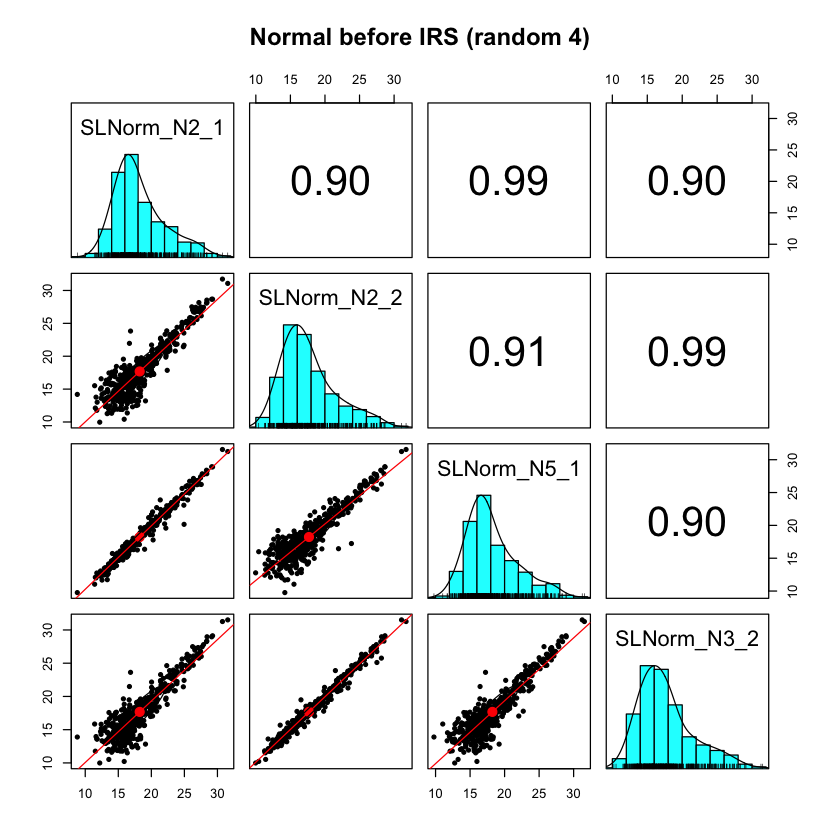

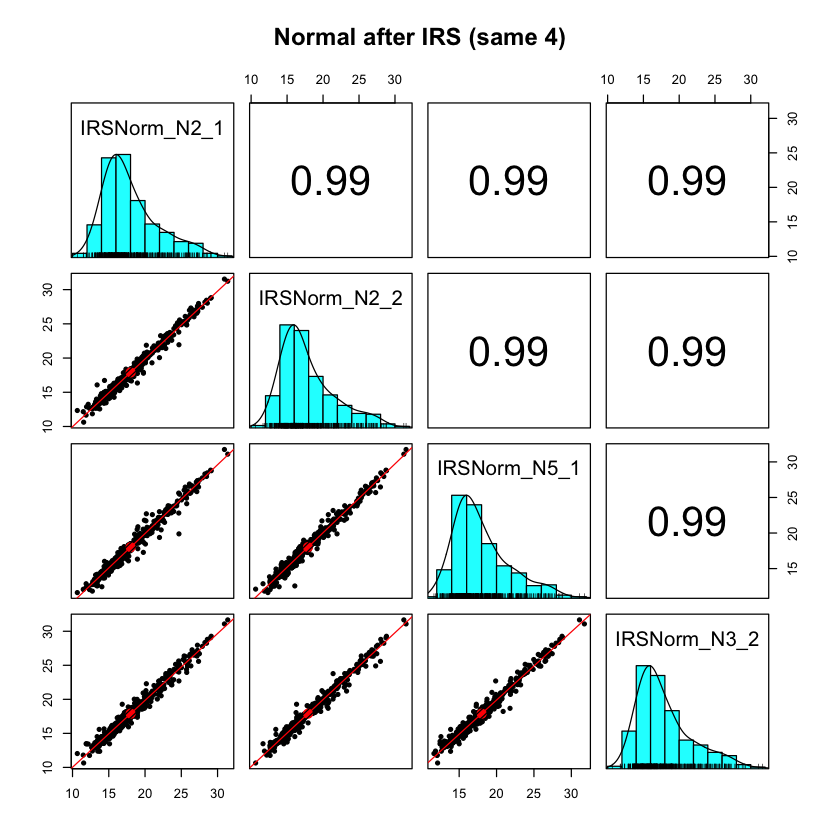

In [6]:
# multi-panel scatter plot grids
N_sample <- sample(1:9, 4)
pairs.panels(log2(sl_N[N_sample]), lm = TRUE, main = "Normal before IRS (random 4)")
pairs.panels(log2(irs_N[N_sample]), lm = TRUE, main = "Normal after IRS (same 4)")

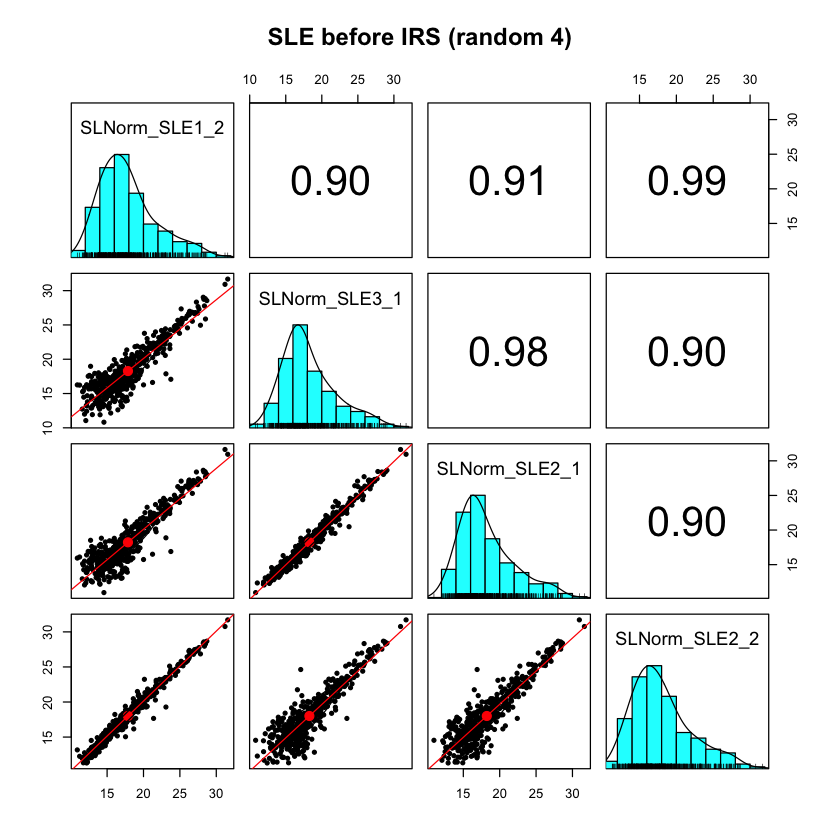

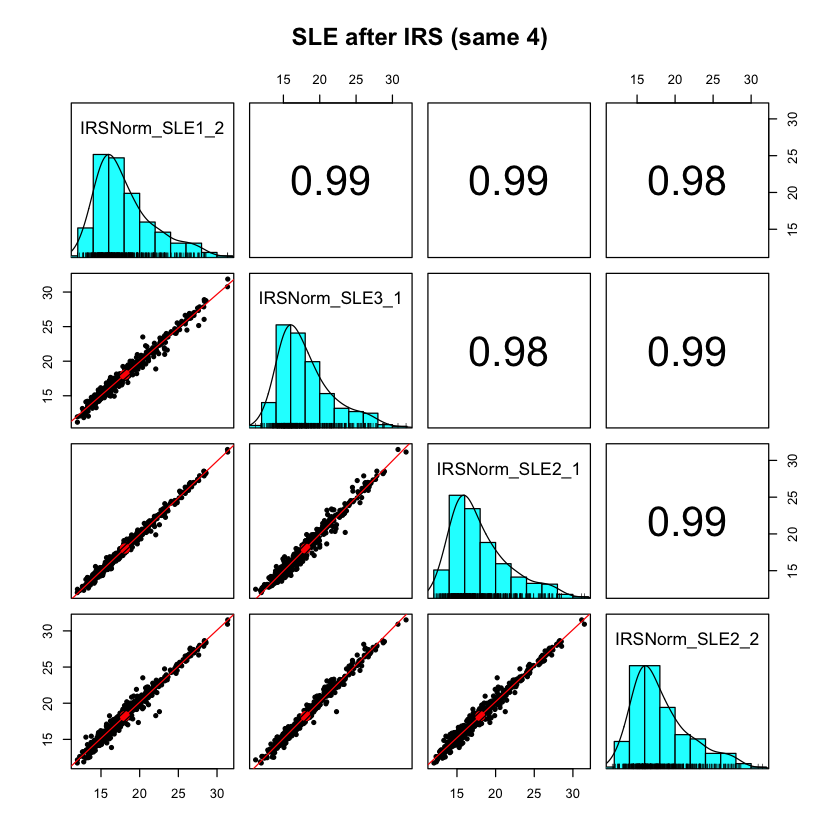

In [7]:
# multi-panel scatter plot grids
SLE_sample  <- sample(1:10, 4)
pairs.panels(log2(sl_SLE[SLE_sample]), lm = TRUE, main = "SLE before IRS (random 4)")
pairs.panels(log2(irs_SLE[SLE_sample]), lm = TRUE, main = "SLE after IRS (same 4)")

### The IRS method is working well

## EdgeR has another very useful data visualization

A multi-dimensional scaling plot (similar to hierarchical clustering or PCA plots) is a good way to check the data. We should expect the samples to group by condition. We can do the clustering before and after IRS to verify that we are able to recovery the true biological differences between groups. We need to load the data into some edgeR data structures and make a couple of function calls to generate the cluster plots.

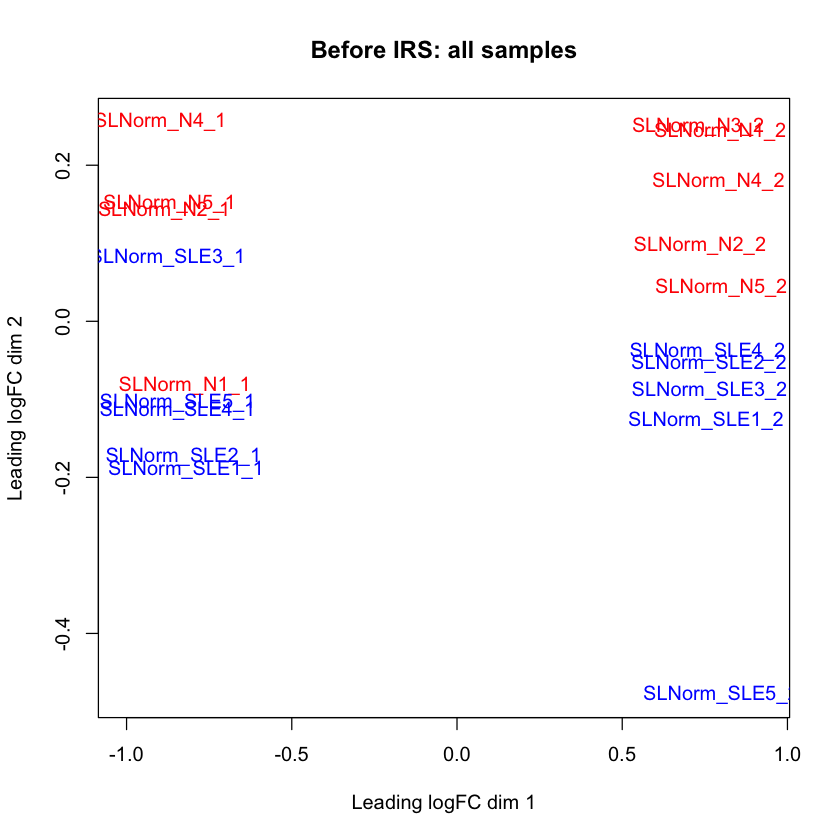

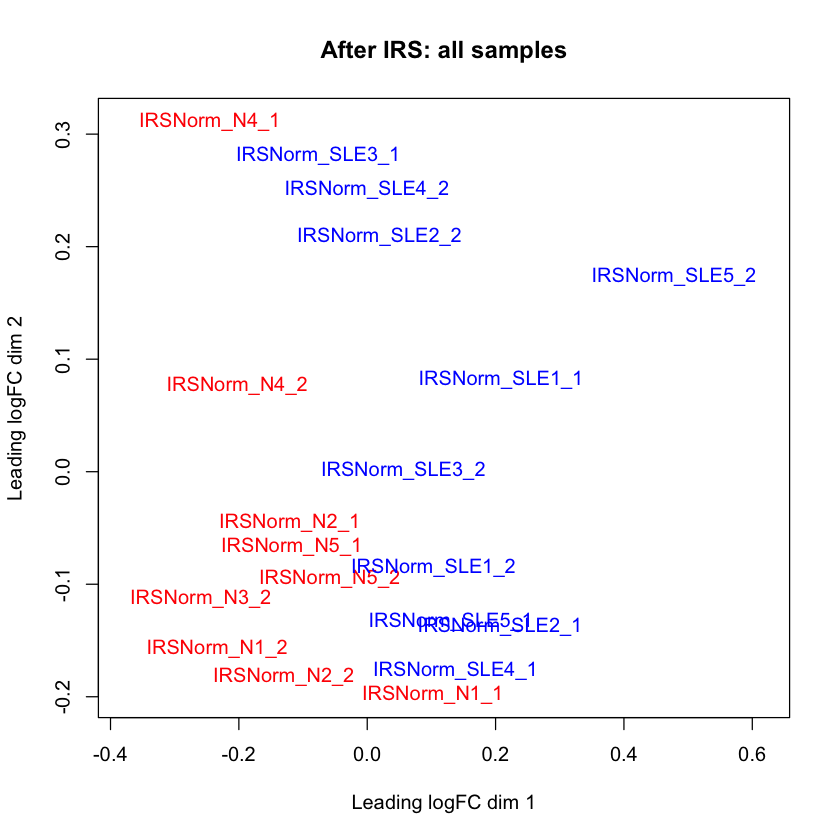

In [8]:
# get the biological sample data into a DGEList object
group = c(rep('N', 9), rep('SLE', 10))
y_sl <- DGEList(counts = cbind(sl_N, sl_SLE), group = group, genes = accessions)
y_irs <- DGEList(counts = cbind(irs_N, irs_SLE), group = group, genes = accessions)

# run TMM normalization (also includes a library size factor)
y_sl <- calcNormFactors(y_sl)
y_irs <- calcNormFactors(y_irs)

# set some colors by condition
colors = c(rep('red', 9), rep('blue', 10))

# check the clustering
plotMDS(y_sl, col = colors, main = "Before IRS: all samples")
plotMDS(y_irs, col = colors, main = "After IRS: all samples")

## Samples cluster by TMT experiment without IRS correction

The **top** MDS plot shows the first TMT experiment on the left and the second experiment on the right. After IRS, (**bottom** plot) we have the biological-condition clustering. 

## Load IRS normalized data into edgeR DGEList object <a name="load_edger"></a>

We need to get the data into some edgeR objects to work with. We can call the calcNormFactors function to perform library size and the trimmed mean of M-values (TMM) normalization. EdgeR combines these two normalizations into one function call. The library size corrections are somewhat redundant because that was done as part of the IRS procedure. The TMM normalization was designed for 'omics data and it makes sense to apply that after we have done the IRS correction. The TMM normalization corrects for compositional differences between biological conditions. If some abundant proteins change expression, since we have equal total amounts of protein per sample, that will make all other protein abundances change to compensate. TMM normalization will detect and correct these situations.

> Robinson, M.D. and Oshlack, A., 2010. A scaling normalization method for differential expression analysis of RNA-seq data. Genome biology, 11(3), p.R25.

In [9]:
# we do not want the technical replicates in the mix for dispersion estimates
irs <- cbind(irs_N, irs_SLE)

# load a new DGEList object (need to update the groups)
y <- DGEList(counts = irs, group = group, genes = accessions) # group was set above
y <- calcNormFactors(y)

# see what the normalization factors look like
y$samples

,group,lib.size,norm.factors
IRSNorm_N1_1,N,11160655952,0.8331351
IRSNorm_N2_1,N,10556055473,1.0710131
IRSNorm_N4_1,N,10636036279,1.1570791
IRSNorm_N5_1,N,10824908504,1.0336480
IRSNorm_N1_2,N,11062184789,0.9607482
IRSNorm_N2_2,N,10891229974,1.0021396
IRSNorm_N3_2,N,11158970137,0.9379835
IRSNorm_N4_2,N,10780640826,0.9959037
IRSNorm_N5_2,N,10718362519,0.8598582
IRSNorm_SLE1_1,SLE,10990158862,0.9744315


## EdgeR normalization factors are mostly close to 1

Unless we have biological conditions with large compositional differences, we expect the library sizes and normalization factors after the calcNormFactors call to be around 1.0.

## Compute the normalized intensities <a name="norm_check"></a>

The deliverable in a proteomics experiment these days are all of the underlying data that generated in and all conclusions. Raw files are needed to allow for independent confirmational analyses. The actual results for a particular analysis can be a bit simpler. Some sort of a PSM report is needed to justify the accepted PSMs (PSMs below some defined cutoffs can be excluded). That is really kind of low-level intermediate information - a dot on an "i" or a cross on a "t". Peptide summaries start to have some biological utility and are important to generate. However, the meat of the results lies in the protein-level summary. There are important proteome-specific sets of details, such as, numbers of PSMs, numbers of peptides, sequence coverage, peptide set groupings, etc. There are annotation details such as accessions and descriptions, gene symbols, sequence lengths, molecular weights, etc. 

When quantitative measurements are included, we need the sample keys, quantitative values, normalized quantitative values, statistical testing results, and maybe some qualitative assessment information (significant or not, etc.). It is nice to have all of the protein details in one table. Part of the notebook collects useful data from the normalizations and statistical testing so that a table can be written that can be added back to extend the proteomics protein summary table into a more complete experimental summary.

The first step in that process is to compute the TMM normalized intensities in their natural scale. EdgeR uses the normalization factors in its modeling but does not compute a table of normalized values.

Overall Factors (lib.size+TMM):
 IRSNorm_N1_1 -> 1.164149
 IRSNorm_N2_1 -> 0.957452
 IRSNorm_N4_1 -> 0.879571
 IRSNorm_N5_1 -> 0.967424
 IRSNorm_N1_2 -> 1.018505
 IRSNorm_N2_2 -> 0.991764
 IRSNorm_N3_2 -> 1.034176
 IRSNorm_N4_2 -> 1.008212
 IRSNorm_N5_2 -> 1.174514
 IRSNorm_SLE1_1 -> 1.010784
 IRSNorm_SLE2_1 -> 0.987429
 IRSNorm_SLE3_1 -> 0.928295
 IRSNorm_SLE4_1 -> 1.094106
 IRSNorm_SLE5_1 -> 0.966406
 IRSNorm_SLE1_2 -> 0.913786
 IRSNorm_SLE2_2 -> 0.845371
 IRSNorm_SLE3_2 -> 1.011987
 IRSNorm_SLE4_2 -> 0.882174
 IRSNorm_SLE5_2 -> 1.265824


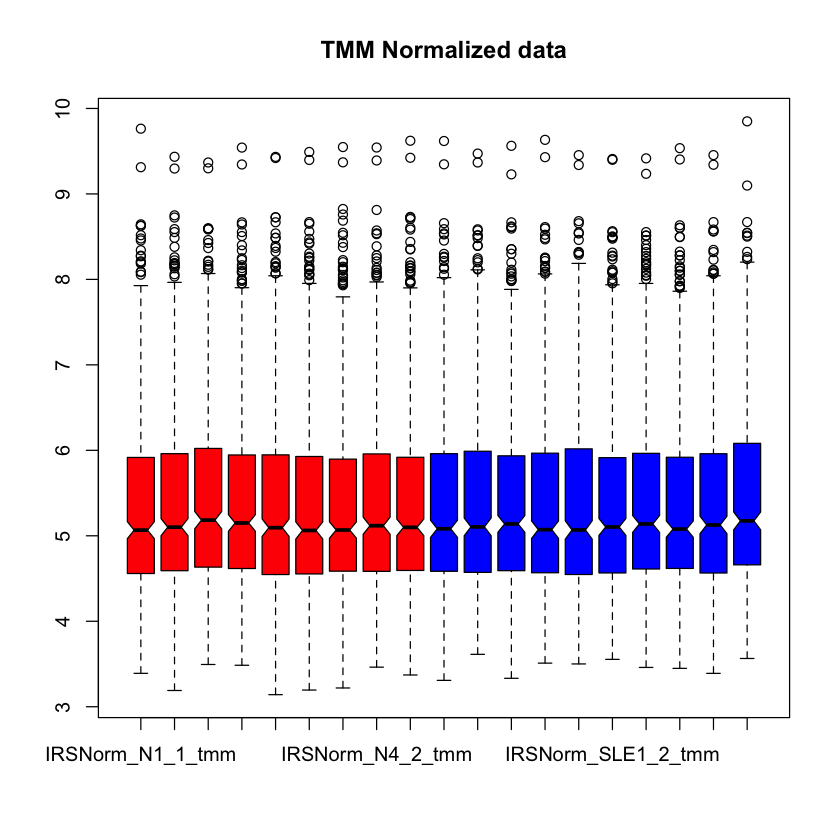

In [10]:
# ================== TMM normalization from DGEList object =====================

apply_tmm_factors <- function(y, color = NULL, plot = TRUE) {
    # computes the tmm normalized data from the DGEList object
        # y - DGEList object
        # returns a dataframe with normalized intensities
    
    # compute grand total (library size) scalings
    lib_facs <- mean(y$samples$lib.size) / y$samples$lib.size

    # the TMM factors are library adjustment factors (so divide by them)
    norm_facs <- lib_facs / y$samples$norm.factors
    cat("Overall Factors (lib.size+TMM):\n", sprintf("%-5s -> %f\n", 
                                                     colnames(y$counts), norm_facs))

    # compute the normalized data as a new data frame
    tmt_tmm <- as.data.frame(sweep(y$counts, 2, norm_facs, FUN = "*"))
    colnames(tmt_tmm) <- str_c(colnames(y$counts), "_tmm")
    
    # visualize results and return data frame
    if(plot == TRUE) {
        boxplot(log10(tmt_tmm), col = color, notch = TRUE, main = "TMM Normalized data")
    }
    tmt_tmm
}

# compute the normalized data as a new data frame
irs_tmm <- apply_tmm_factors(y, colors)

## Check the normalizations with box plots

Box plots for well normalized data should be similar in size and the medians should align with each other. There can be problems with the data that may not be apparent with boxplots (some data distortions can average out and not appear different with boxplots). Regardless, we should have boxplots with good median alignment. Good boxplot behavior is a necessary but not sufficient requirement of proper normalization.

The boxplots here look worse than we typically see from cell lysates where we have much larger proteomes. Fewer proteins with such a wide range of abundance is something that we need to keep in mind for serum samples.

We will use ggplot2 this time and flip the graph on its side, so we can read the labels easier. We need tidy (long form) data for ggplot:

In [11]:
long_results <- gather(irs_tmm, key = "sample", value = "intensity") %>%
  mutate(log_int = log10(intensity)) %>%
  extract(sample, into = 'group', ".*?_(.*?)\\d", remove = FALSE)
head(long_results)

sample,group,intensity,log_int
IRSNorm_N1_1_tmm,N,5797252580,9.763222
IRSNorm_N1_1_tmm,N,2054106382,9.312623
IRSNorm_N1_1_tmm,N,422349513,8.625672
IRSNorm_N1_1_tmm,N,301252193,8.478930
IRSNorm_N1_1_tmm,N,441066666,8.644504
IRSNorm_N1_1_tmm,N,285693766,8.455901


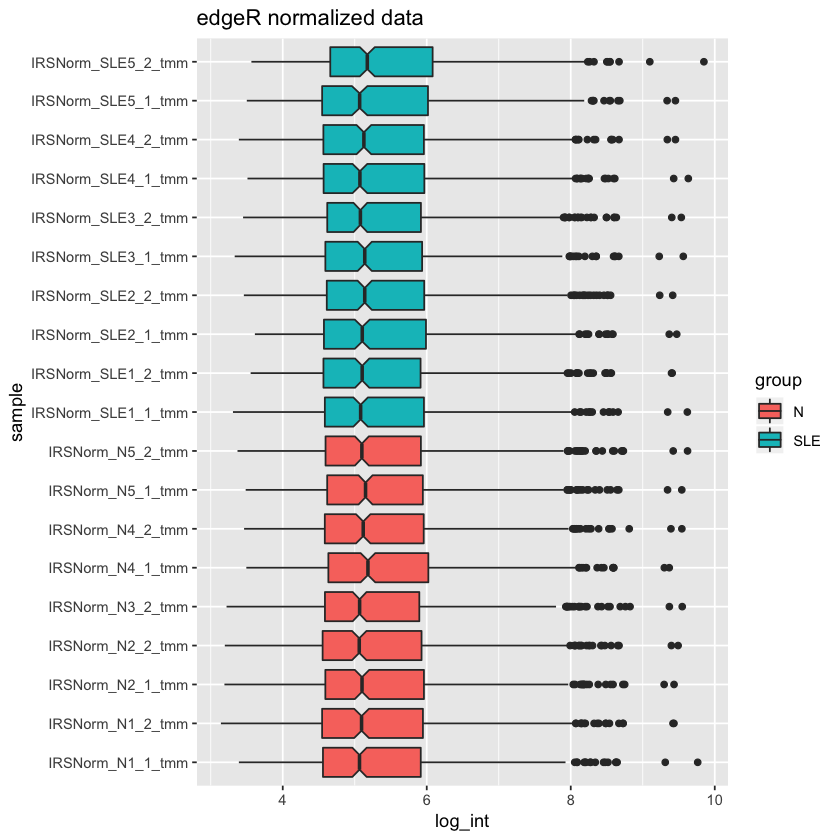

In [12]:
ggplot(long_results, aes(x = sample, y = log_int, fill = group)) +
  geom_boxplot(notch = TRUE) +
  coord_flip() + 
  ggtitle("edgeR normalized data")

## ggplot can easily do other plot styles

Boxplots and density plots are closely related. We can easily see the smoothed density distributions for each sample.

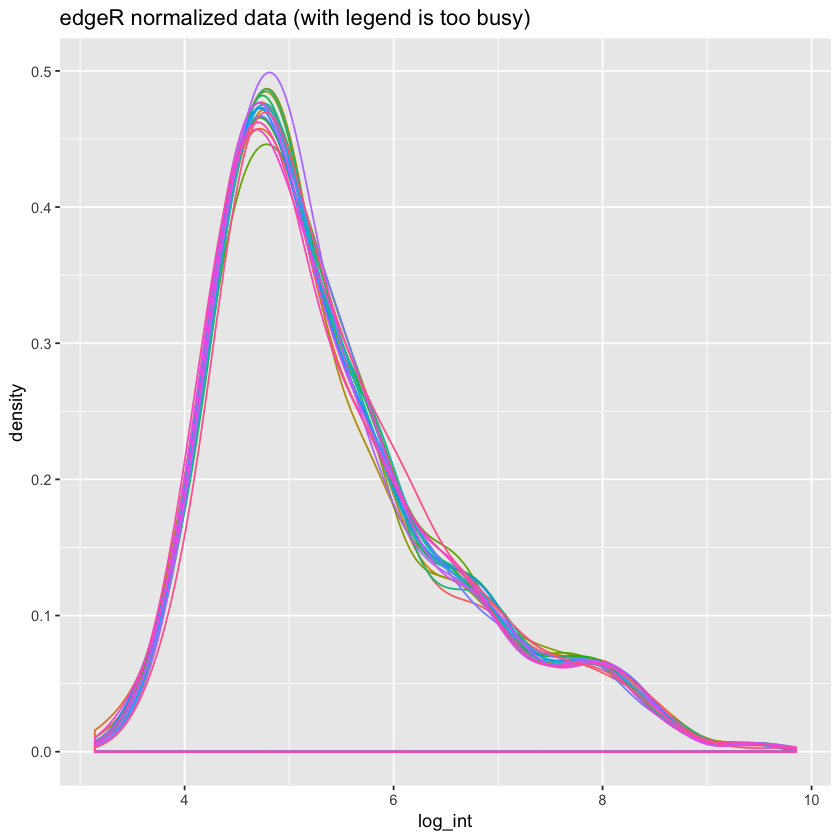

In [13]:
ggplot(long_results, aes(x = log_int, color = sample)) +
  geom_density() +
  guides(color = FALSE) +
  ggtitle("edgeR normalized data (with legend is too busy)")

## How reproducible are samples within conditions?

The distributions of Coefficients of Variation (CVs) are another way to get an idea of how individual proteins are behaving. This seems to be an effective way to assess proper normalization in these experiments. We will compute CV distributions for each of the two biological conditions.

In [14]:
# we can compare CVs before and after IRS
sl <- cbind(sl_N, sl_SLE)

# save column indexes for different conditions (indexes to data_raw frame)
# these make things easier (and reduce the chance for errors)
N <- 1:9
SLE <- 10:19

# create a CV computing function
CV <- function(df) {
    ave <- rowMeans(df)
    sd <- apply(df, 1, sd)
    cv <- 100 * sd / ave
}

# put CVs in data frames to simplify plots and summaries
cv_frame <- data.frame(N_sl = CV(sl[N]), N_final = CV(irs_tmm[N]), 
                       SLE_sl = CV(sl[SLE]), SLE_final = CV(irs_tmm[SLE]))


# see what the median CV values are
medians <- apply(cv_frame, 2, FUN = median)
print("Median CVs by condition, before/after IRS (%)")
round(medians, 1)

[1] "Median CVs by condition, before/after IRS (%)"


N_sl   N_final    SLE_sl SLE_final 
     45.2      21.6      45.7      22.4

## Use ggplot to explore the CV data

We see some big improvements in median CVs after IRS and TMM normalizations. We can also check the full distributions.

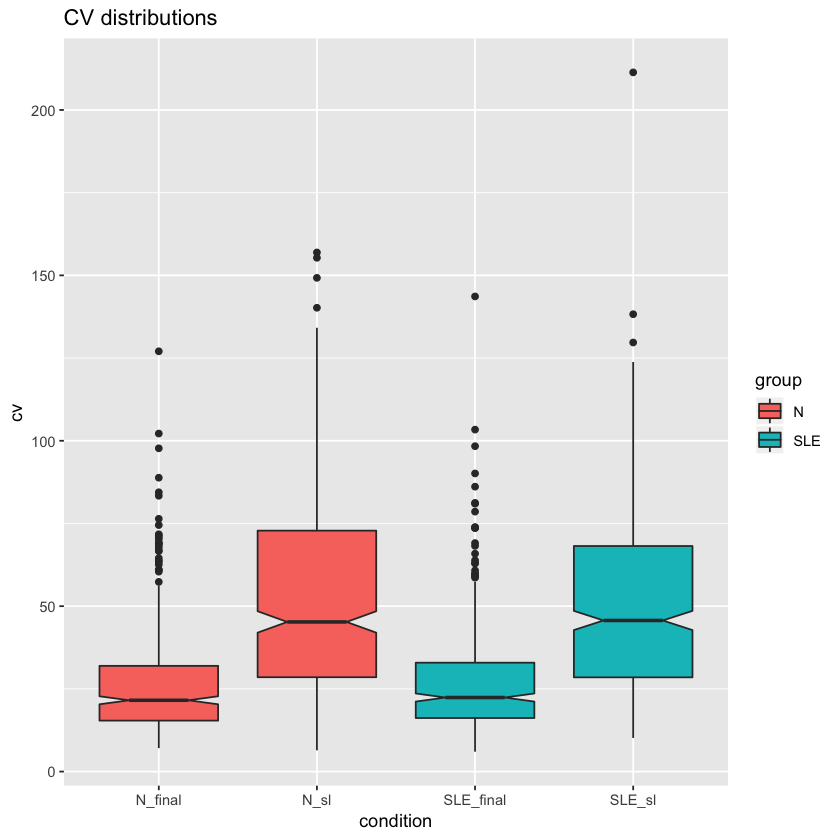

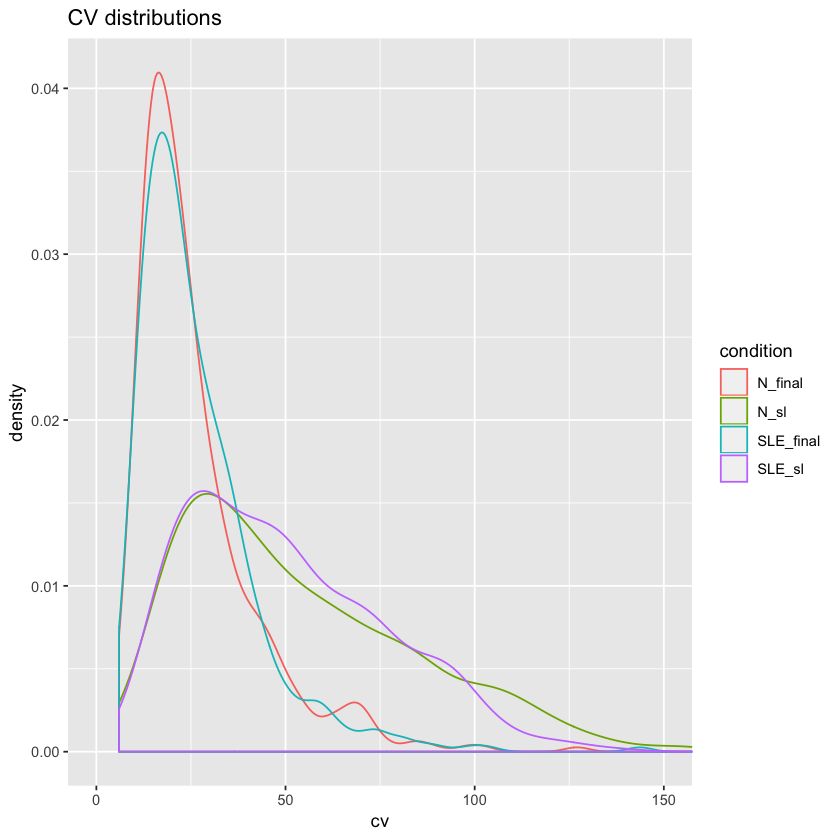

In [15]:
# see what the CV distibutions look like
# need long form for ggplot
long_cv <- gather(cv_frame, key = "condition", value = "cv") %>%
  extract(condition, into = 'group', "(.*?)_+", remove = FALSE)

# traditional boxplots
cv_plot <- ggplot(long_cv, aes(x = condition, y = cv, fill = group)) +
  geom_boxplot(notch = TRUE) +
  ggtitle("CV distributions")

# vertical orientation
cv_plot

# horizontal orientation
#cv_plot + coord_flip()

# density plots
ggplot(long_cv, aes(x = cv, color = condition)) +
  geom_density() +
  coord_cartesian(xlim = c(0, 150)) +
  ggtitle("CV distributions")

## Data are improved by the normalizations

The CVs improve with IRS and TMM normalizations. The median CVs get smaller, but the distributions of the CV values are much improved with considerably smaller inter-quartile ranges.  

## Normalized data has been checked and looks pretty good

We have used scatter plots, correlation coefficients, clustering, and boxplots to verify that the IRS procedure and TMM normalization behaved as expected. None of the biological samples needed any excessive normalization factors or appeared as an outlier in the cluster views (the N3 sample was already removed). Everything looks ready for statistical testing with edgeR.

----

# Compare Normal to SLE samples <a name="DE"></a>

## Compute the shared variance trend

One of the most powerful features of edgeR (and limma) is computing variances across larger numbers of genes (proteins) to get more robust variance estimates for small replicate experiments. Here, we have 19 samples across all conditions to use to improve the variance estimates and reduce false positive differential expression (DE) candidates. We have an edgeR estimateDisp function that does all of this and a visualization function to check the result.

We loaded the IRS data into DGEList object "y" a few cells above and did the normalization step. We need to estimate the dispersion parameters before we can do the actual statistical testing. This only needs to be done once. Each exact test will take two conditions and compare them using the normalization factors and dispersion estimates saved in "y".

Design matrix not provided. Switch to the classic mode.


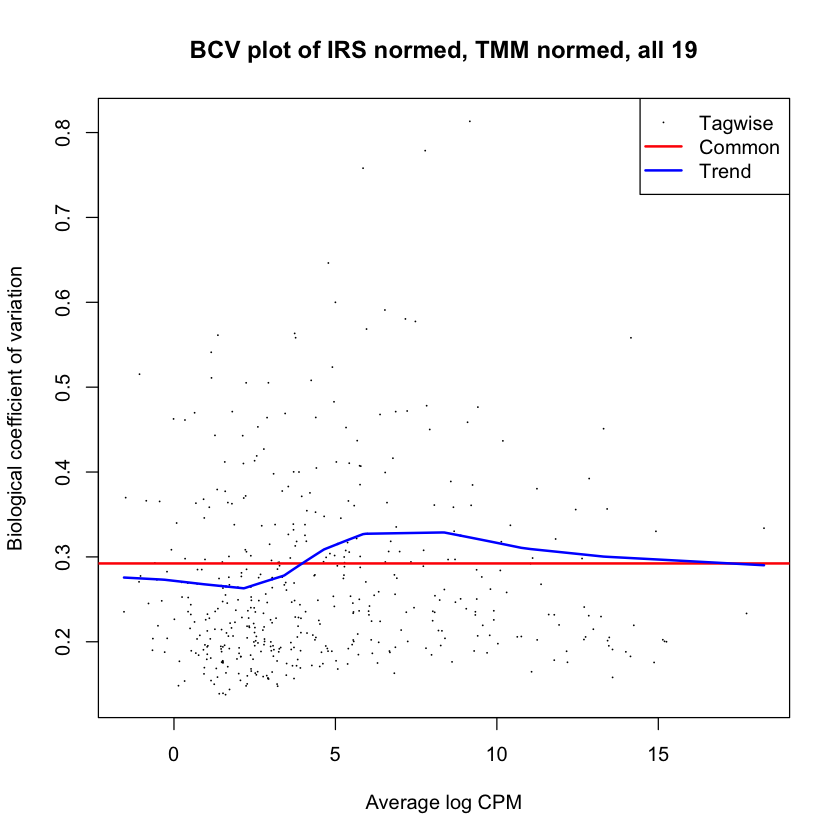

In [16]:
# compute dispersions and plot BCV
y <- estimateDisp(y)
plotBCV(y, main = "BCV plot of IRS normed, TMM normed, all 19")

### This experiment is very sparse

467 proteins is a lot smaller number that the 2000 to 5000 we typically work with. There is also a lot of variability to the protein variances.

## Exact test of N vs SLE using experiment-wide dispersion

We will specify the pair of interest for the exact test in edgeR and use the experiment-wide dispersion. The decideTestsDGE call will tell us how many up and down regulated candidates we have at an FDR of 0.10. The topTags call does the Benjamini-Hochberg multiple testing corrections. We save the test results in `tt`. We use a handy MA (mean-average) plotting function from limma to visualize the DE candidates, and then check the p-value distribution.

       SLE-N
Down       7
NotSig   436
Up        24

,genes,logFC,logCPM,PValue,FDR
105,sp|Q15485|FCN2_HUMAN,2.3592442,6.5453111,6.458743e-30,3.016233e-27
186,sp|P02775|CXCL7_HUMAN,1.2460548,4.7013370,4.532360e-21,1.058306e-18
356,sp|Q8TDL5|BPIB1_HUMAN,-0.9750626,2.2887532,5.905294e-10,9.192574e-08
108,sp|P07996|TSP1_HUMAN,1.7469210,6.7806363,1.235585e-09,1.442545e-07
183,sp|P10720|PF4V_HUMAN,1.1569501,4.8297518,1.891381e-08,1.766550e-06
149,sp|P00915|CAH1_HUMAN,1.4094196,5.7624301,8.345661e-08,6.232982e-06
422,sp|P05067|A4_HUMAN,0.8339530,1.0368632,9.342800e-08,6.232982e-06
302,sp|P00918|CAH2_HUMAN,0.8645156,3.0437031,1.080005e-06,6.304528e-05
430,sp|P01033|TIMP1_HUMAN,0.6445417,0.6366447,1.623264e-05,8.422938e-04
176,sp|P40197|GPV_HUMAN,0.7984156,4.6326481,5.327560e-05,2.487971e-03


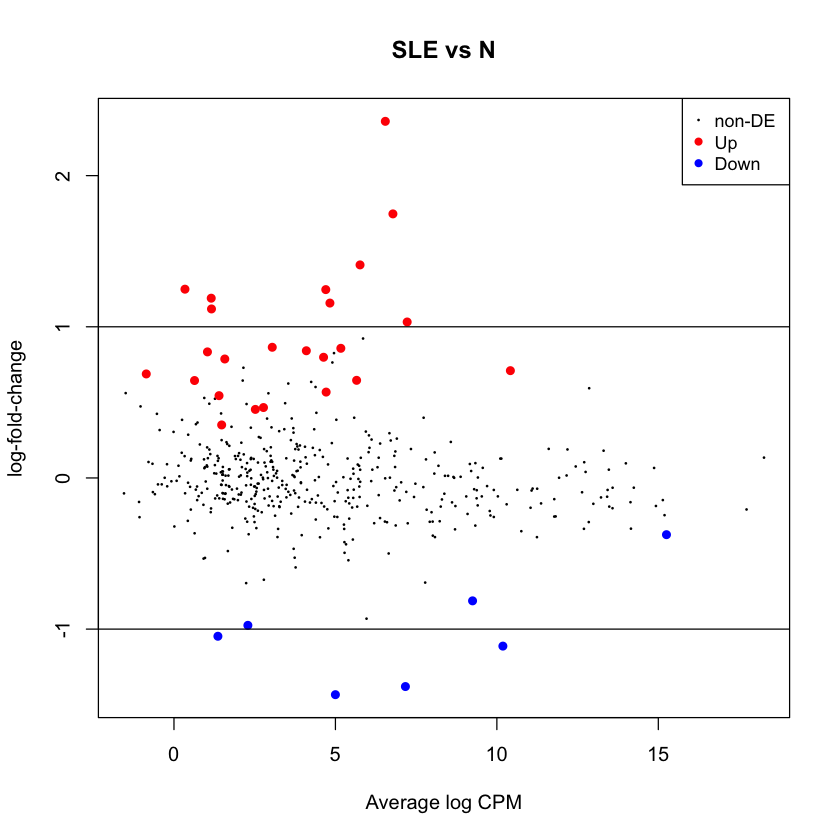

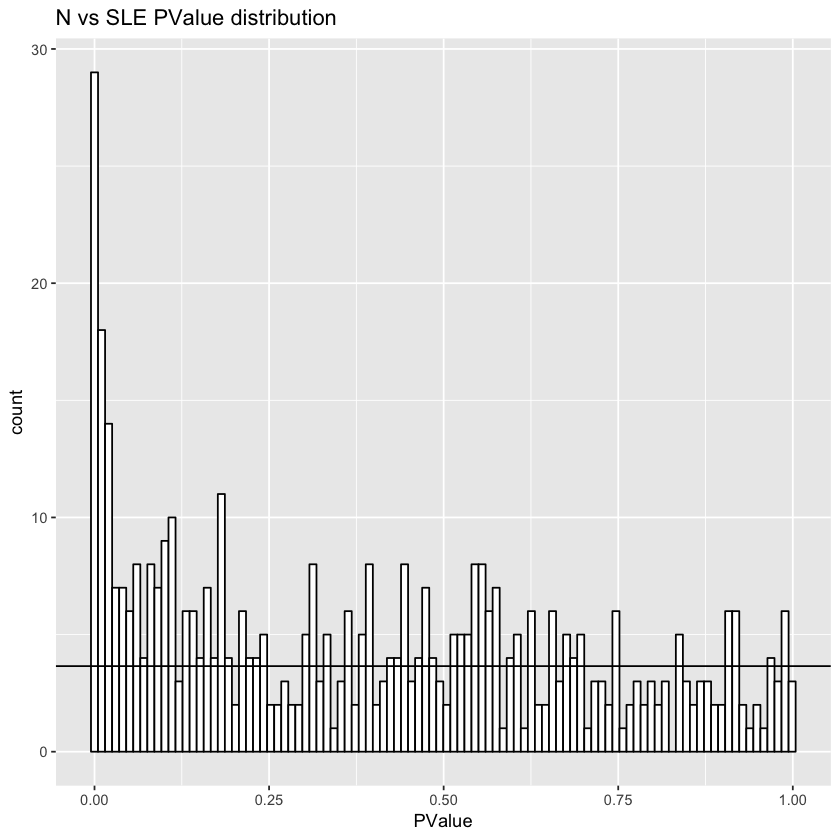

In [17]:
# the exact test object has columns like fold-change, CPM, and p-values
et <- exactTest(y, pair = c("N", "SLE"))

# this counts up, down, and unchanged genes (proteins) at 10% FDR
summary(decideTestsDGE(et, p.value = 0.10))

# the topTags function adds the BH FDR values to an exactTest data frame 
# make sure we do not change the row order (the sort.by parameter)!
topTags(et, n = 31)
tt <- topTags(et, n = Inf, sort.by = "none")
tt <- tt$table    # tt is a list. We just need the "table" data frame

# make an MD plot (like MA plot)
plotMD(et, p.value = 0.10)
abline(h = c(-1, 1), col = "black")

# check the p-value distribution
ggplot(tt, aes(PValue)) + 
  geom_histogram(bins = 100, fill = "white", color = "black") + 
  geom_hline(yintercept = mean(hist(et$table$PValue, breaks = 100, 
                                    plot = FALSE)$counts[26:100])) +
  ggtitle("N vs SLE PValue distribution")

## Candidates and p-values look okay

The number of candidates is modest, and more are over-expressed in SLE, as can be seen in the MA plot. The p-value distribution has a nice flat distribution for larger p-values (from non-DE candidates) and a sharper spike at small p-values from true DE candidates.

The D'Angelo publication evaluated statistical models on this data. They looked at generalized linear models, mixed models, and limma (a close cousin to edgeR). There data analysis pipeline was Mascot/Percolator in Proteome Discoverer 1.4. That includes single peptide per protein IDs. The PAW processing requires 2 peptides per protein. They used fully trpytic cleavages for secreted proteins and semi-tryptic would have been more appropriate. There were a lot of keratins and the families of the MARS-6 proteins that need to be excluded from the quantitative analysis. All of this makes comparing protein identification numbers difficult. The number of DE candidates at a 5% FDR for four statijstical models were listed in Table 6. They had a range of candidates from 10 to 13 (limma had 12). We have 21 at the 5% FDR cut. This is double the number of candidates with a more-strict protein ID criteria.  

## Compute averages, flag candidates, and save the pair-wise test results

We will add the statistical testing results (logFC, p-values, and FDR), condition intensity averages, and candidate status to the `results` data frame (which has the TMM-normalized data).

candidate,n
high,14
med,7
low,10
no,436


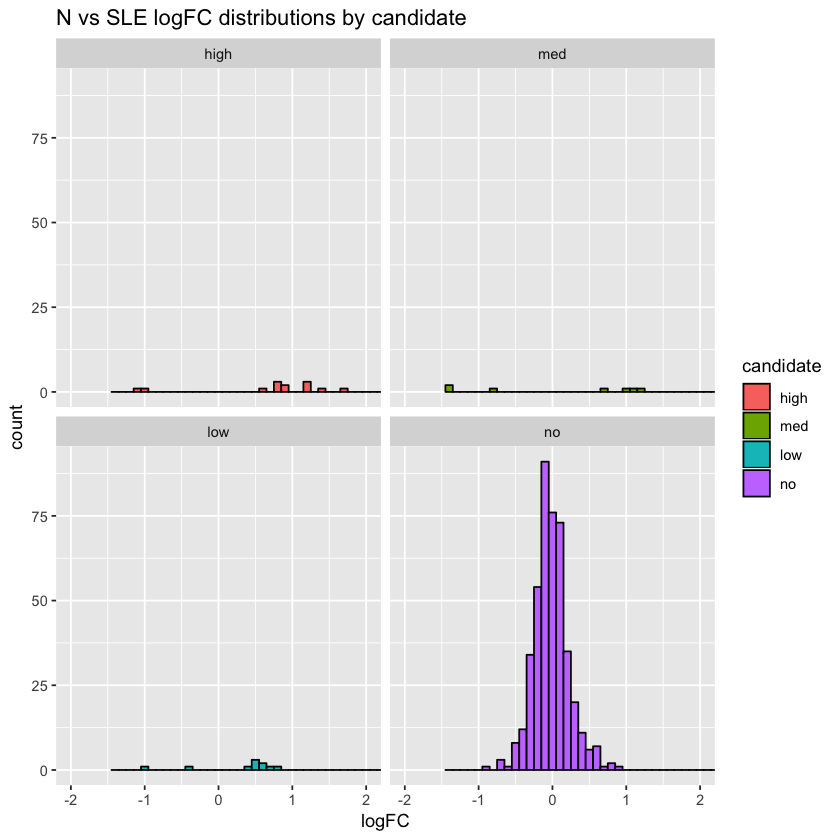

In [18]:
# get the averages within each condition 
# results already has the normalized data in its left columns
tt$ave_N <- rowMeans(irs_tmm[N])
tt$ave_SLE <- rowMeans(irs_tmm[SLE])

# add the cadidate status column
tt <- tt %>%
  mutate(candidate = cut(FDR, breaks = c(-Inf, 0.01, 0.05, 0.10, 1.0),
  labels = c("high", "med", "low", "no")))

tt %>% count(candidate)  # count candidates

ggplot(tt, aes(x = logFC, fill = candidate)) +
  geom_histogram(binwidth=0.1, color = "black") +
  facet_wrap(~candidate) +
  coord_cartesian(xlim = c(-2, 2)) +
  ggtitle("N vs SLE logFC distributions by candidate")

In [19]:
# ================= reformat edgeR test results ================================

collect_results <- function(df, tt, x, xlab, y, ylab) {
    # Computes new columns and extracts some columns to make results frame
        # df - data in data.frame
        # tt - top tags table from edgeR test
        # x - columns for first condition
        # xlab - label for x
        # y - columns for second condition
        # ylab - label for y
        # returns a new dataframe
    
    # condition average vectors
    ave_x <- rowMeans(df[x])
    ave_y <- rowMeans(df[y])
    
    # FC, direction, candidates
    fc <- ifelse(ave_y > ave_x, (ave_y / ave_x), (-1 * ave_x / ave_y))
    direction <- ifelse(ave_y > ave_x, "up", "down")
    candidate <- cut(tt$FDR, breaks = c(-Inf, 0.01, 0.05, 0.10, 1.0), 
                     labels = c("high", "med", "low", "no"))
    
    # make data frame
    temp <- cbind(df[c(x, y)], data.frame(logFC = tt$logFC, FC = fc, 
                                          PValue = tt$PValue, FDR = tt$FDR, 
                                          ave_x = ave_x, ave_y = ave_y, 
                                          direction = direction, candidate = candidate, 
                                          Acc = tt$genes)) 
    
    # fix column headers for averages
    names(temp)[names(temp) %in% c("ave_x", "ave_y")]  <- str_c("ave_", c(xlab, ylab))    
    
    temp # return the data frame
}

# get the results
results <- collect_results(irs_tmm, tt, N, "N", SLE, "SLE")

## Main summary plots

We have many comparisons to visualize, so we will make a function to generate a series of plots. We will make: an MA plot with candidates highlighted by color, faceted MA plots separated by candidate status, a scatter plot with candidates highlighted by color, faceted scatter plots separated by candidate status, and a volcano plot with candidates highlighted by color.

In [20]:
transform <- function(results, x, y) {
    # Make data frame with some transformed columns
        # results - results data frame
        # x - columns for x condition
        # y - columns for y condition
        # return new data frame
    df <- data.frame(log10((results[x] + results[y])/2), 
                     log2(results[y] / results[x]), 
                     results$candidate,
                     -log10(results$FDR))
    colnames(df) <- c("A", "M", "candidate", "P")
    
    df # return the data frame
}

MA_plots <- function(results, x, y, title) {
    # makes MA-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # returns a list of plots 
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # 2-fold change lines
    ma_lines <- list(geom_hline(yintercept = 0.0, color = "black"),
                     geom_hline(yintercept = 1.0, color = "black", linetype = "dotted"),
                     geom_hline(yintercept = -1.0, color = "black", linetype = "dotted"))

    # make main MA plot
    ma <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scale_y_continuous(paste0("logFC (", y, "/", x, ")")) +
        scale_x_continuous("Ave_intensity") +
        ggtitle(title) + 
        ma_lines
    
    # make separate MA plots
    ma_facet <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scale_y_continuous(paste0("log2 FC (", y, "/", x, ")")) +
        scale_x_continuous("log10 Ave_intensity") +
        ma_lines +
        facet_wrap(~ candidate) +
        ggtitle(str_c(title, " (separated)"))

    # make the plots visible
    print(ma)
    print(ma_facet)
}    

scatter_plots <- function(results, x, y, title) {
    # makes scatter-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # returns a list of plots
    
    # 2-fold change lines
    scatter_lines <- list(geom_abline(intercept = 0.0, slope = 1.0, color = "black"),
                          geom_abline(intercept = 0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          geom_abline(intercept = -0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          scale_y_log10(),
                          scale_x_log10())

    # make main scatter plot
    scatter <- ggplot(results, aes_string(x, y)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        ggtitle(title) + 
        scatter_lines

    # make separate scatter plots
    scatter_facet <- ggplot(results, aes_string(x, y)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scatter_lines +
        facet_wrap(~ candidate) +
        ggtitle(str_c(title, " (separated)")) 

    # make the plots visible
    print(scatter)
    print(scatter_facet)
}

volcano_plot <- function(results, x, y, title) {
    # makes a volcano plot
        # results - a data frame with edgeR results
        # x - string for the x-axis column
        # y - string for y-axis column
        # title - plot title string
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # build the plot
    ggplot(temp, aes(x = M, y = P)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        xlab("log2 FC") +
        ylab("-log10 FDR") +
        ggtitle(str_c(title, " Volcano Plot"))
}

## DE Candidate Plots for Normal vs SLE serum

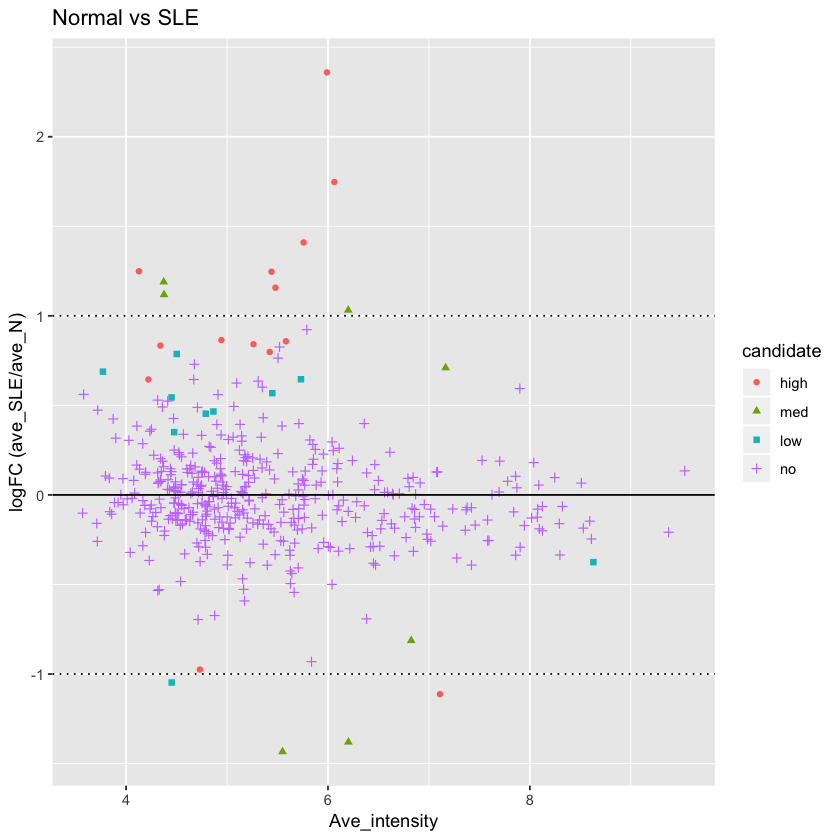

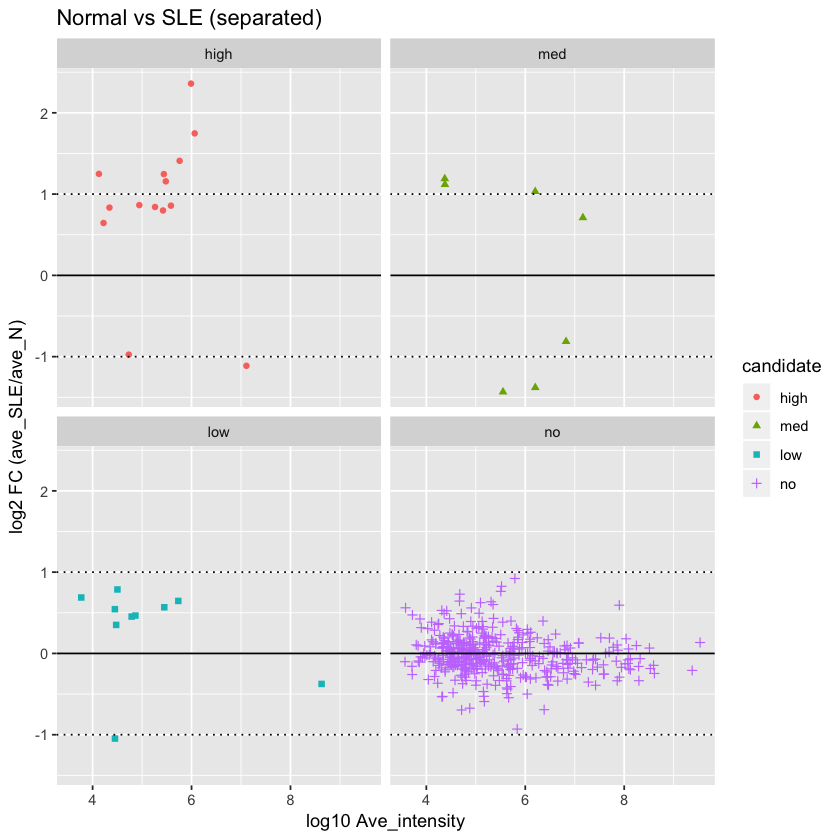

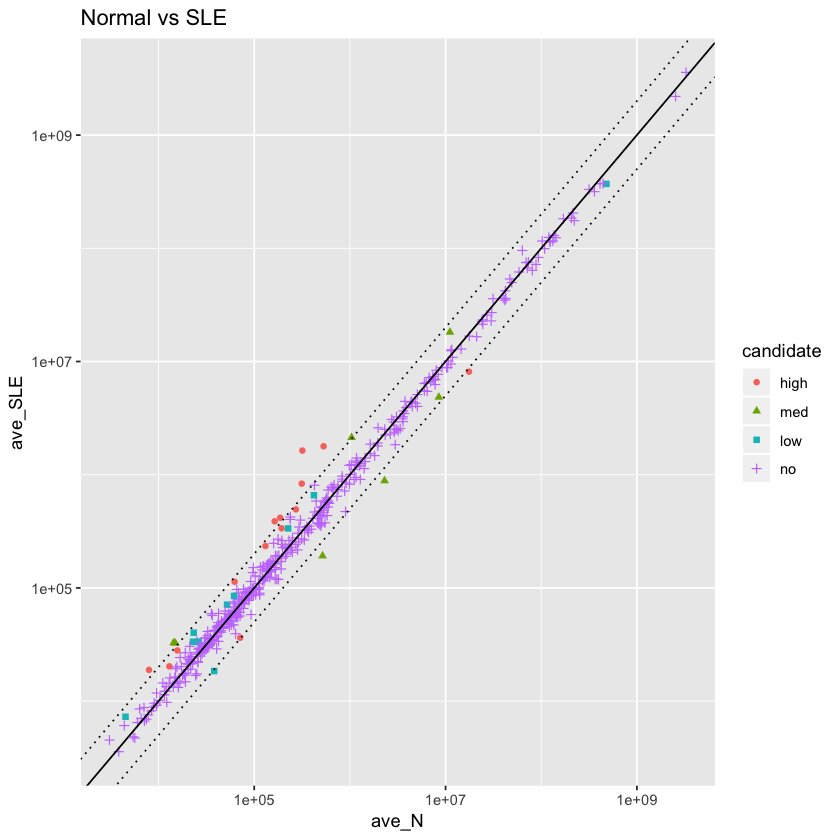

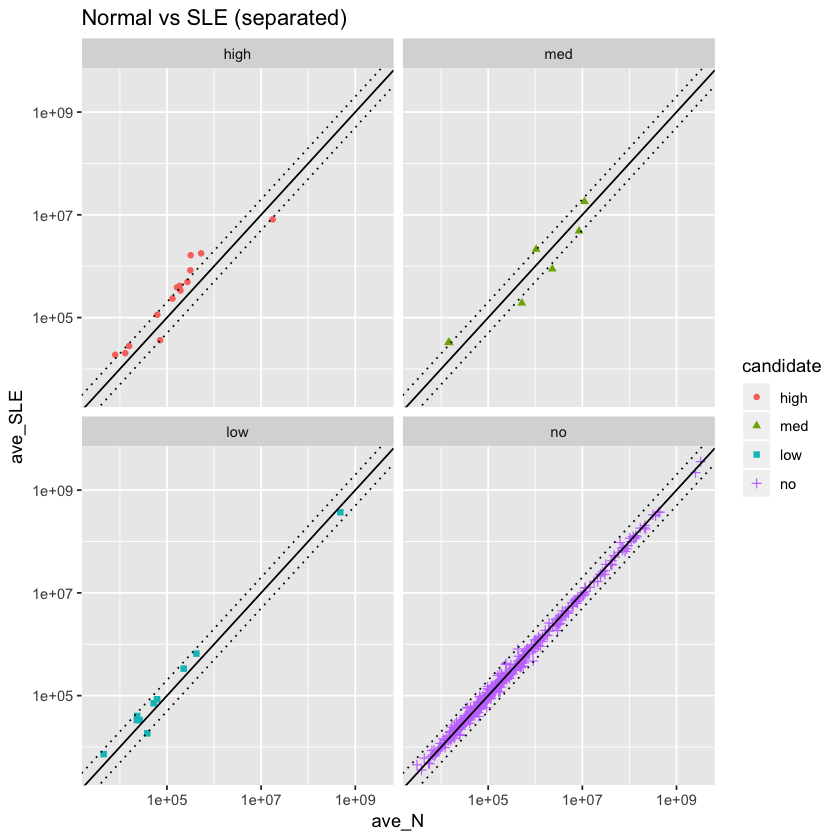

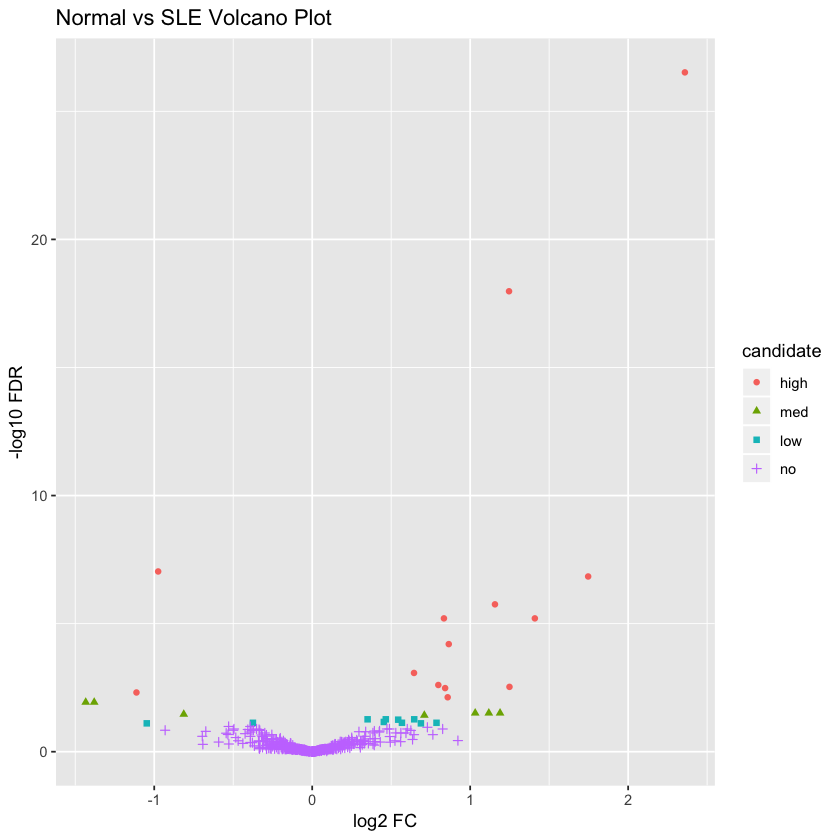

In [21]:
# make the DE plots
MA_plots(results, "ave_N", "ave_SLE", "Normal vs SLE")
scatter_plots(results, "ave_N", "ave_SLE", "Normal vs SLE")
volcano_plot(results, "ave_N", "ave_SLE", "Normal vs SLE")

### Many candidates are less than 2-fold

The fold-changes for candidates are not particularly large. Many of the statistically significant proteins have less than 2-fold changes. This could be due to using MS2 reporter ions instead of the newer SPS MS3 method. There are more candidates with larger fold changes that have over-expression in SLE. The candidates are spread out over the 5-decades of protein intensities.

Note: Protein total reporter ion intensity is well correlated with protein total MS1 feature intensities. In other words, it is a good relative protein abundance measure.

## Plot reporter ion intensities for the top 10 up/down candidates (by FDR) <a name="topN"></a>

The normal data points are in red and the SLE samples are in blue. The protein identifier, the average intensity, the individual test p-value (not the FDR), and the traditional fold-change are used as plot labels.

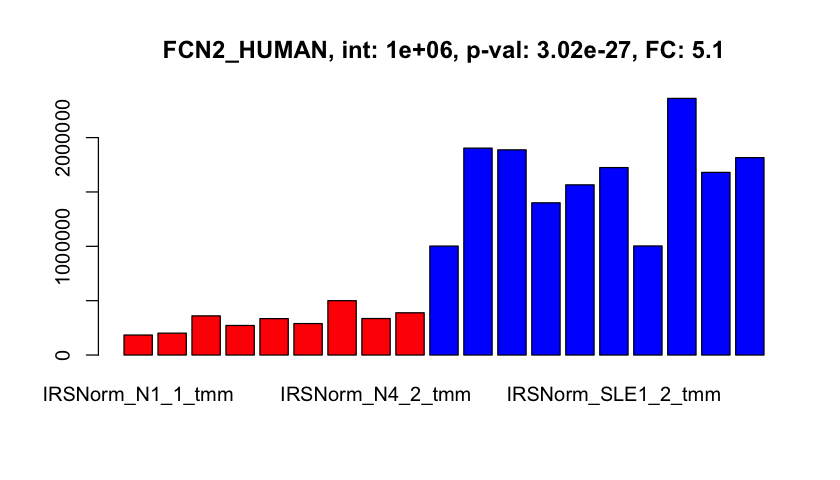

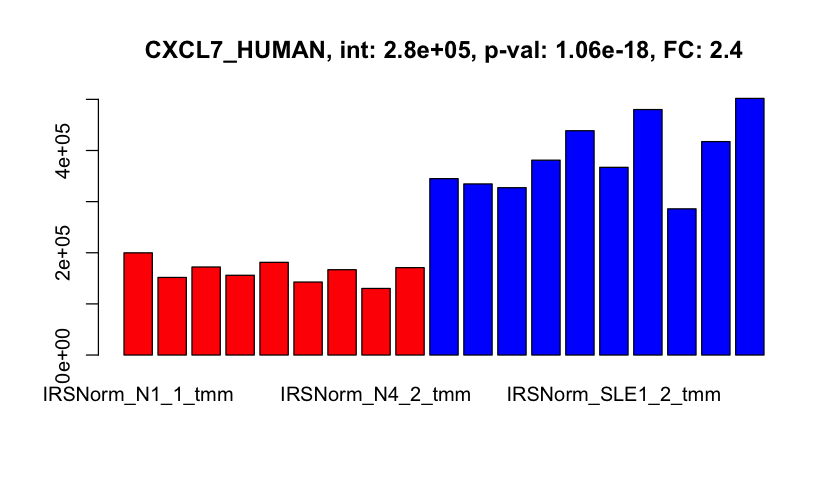

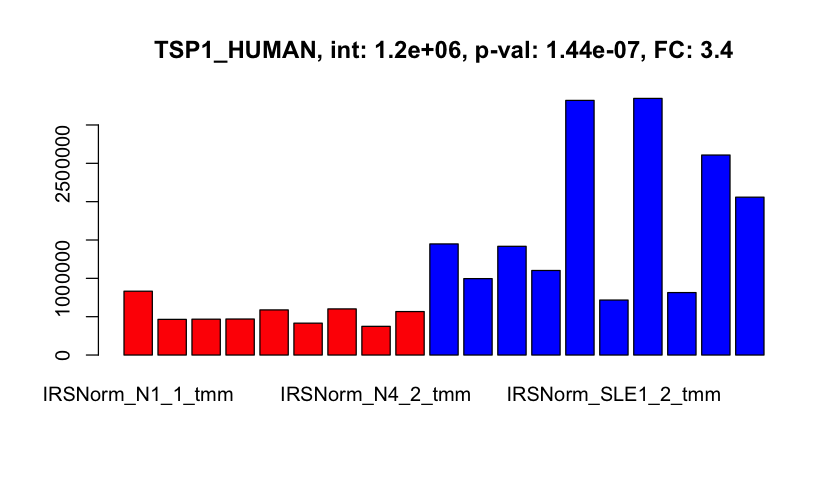

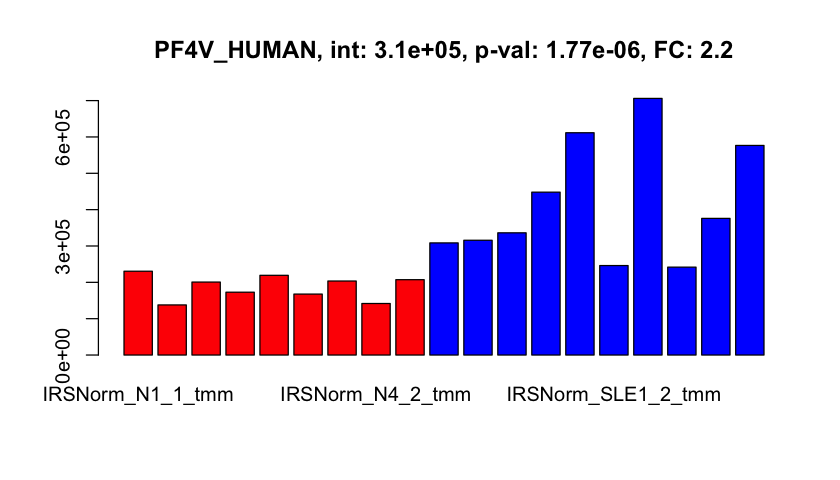

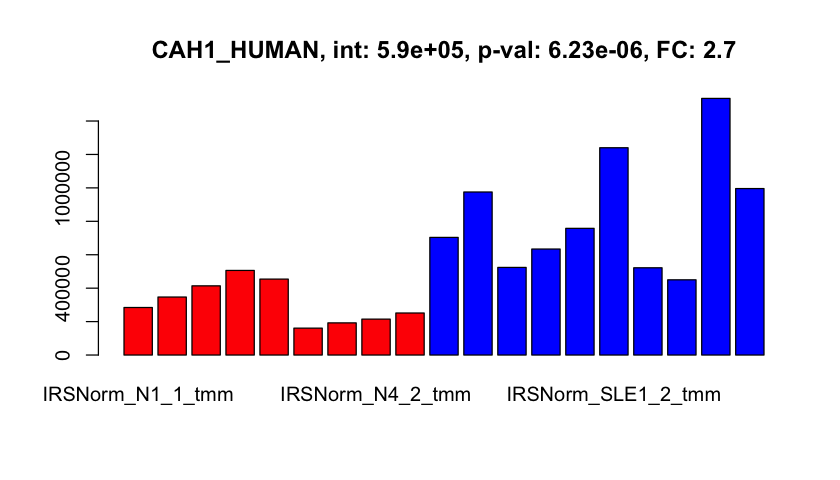

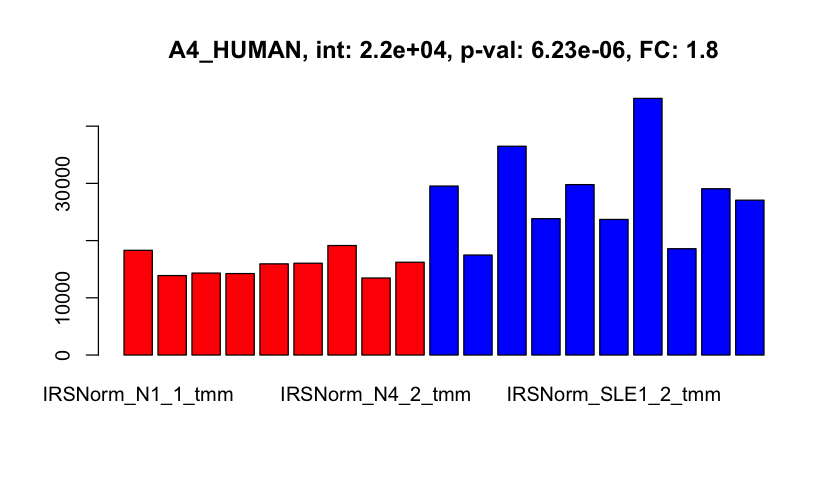

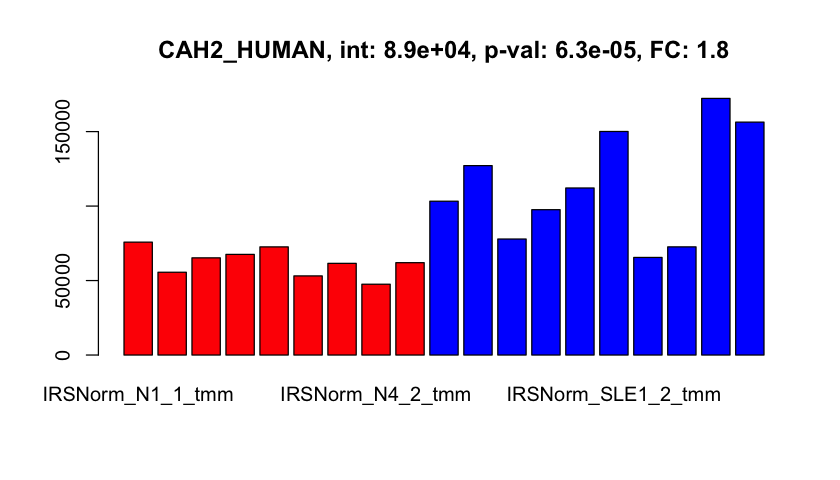

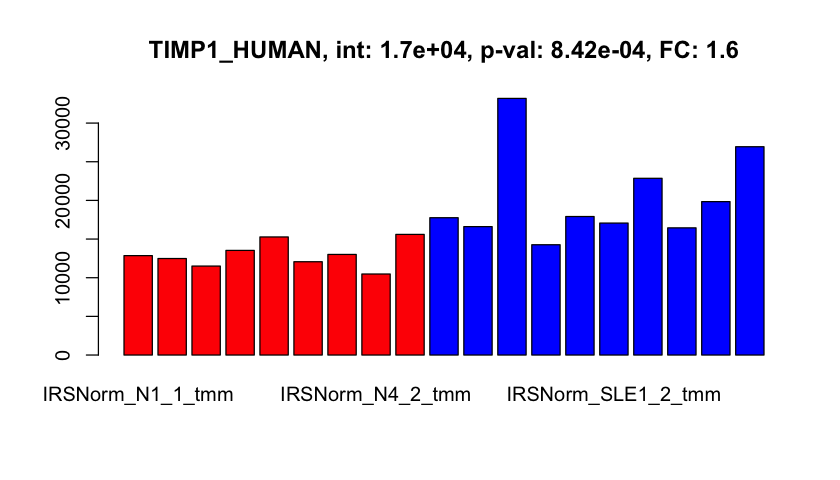

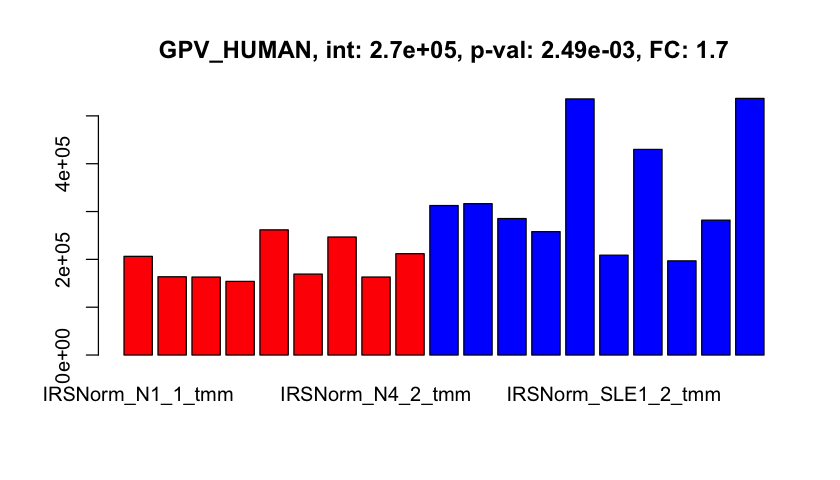

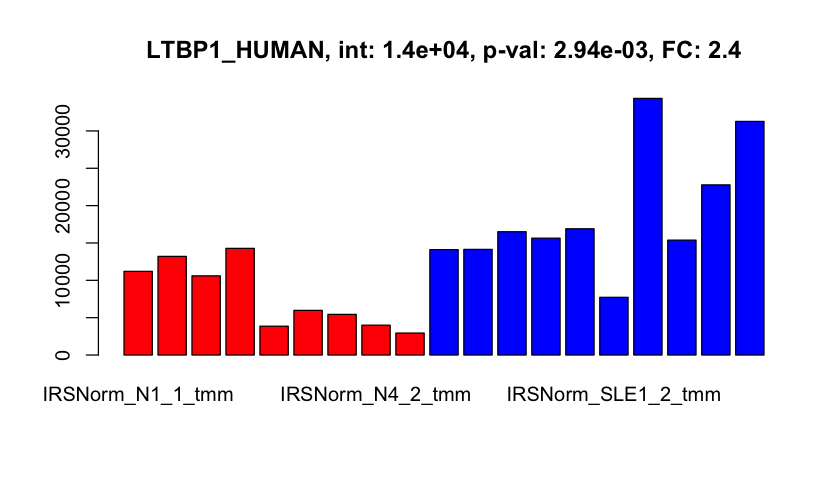

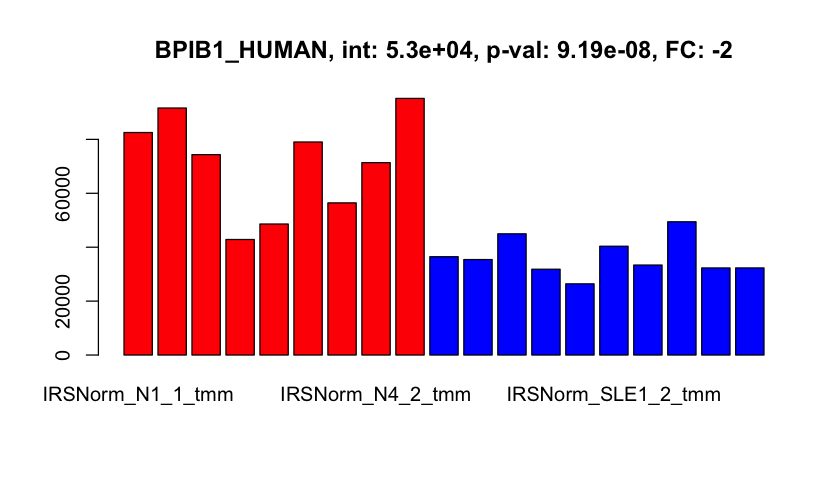

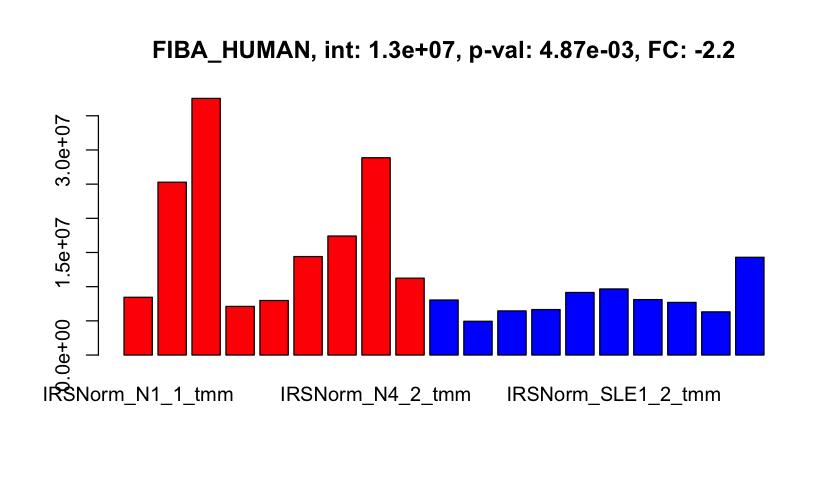

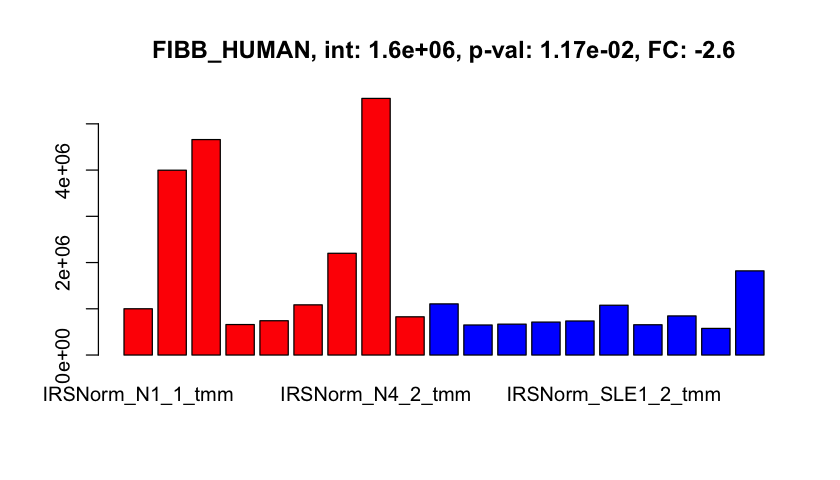

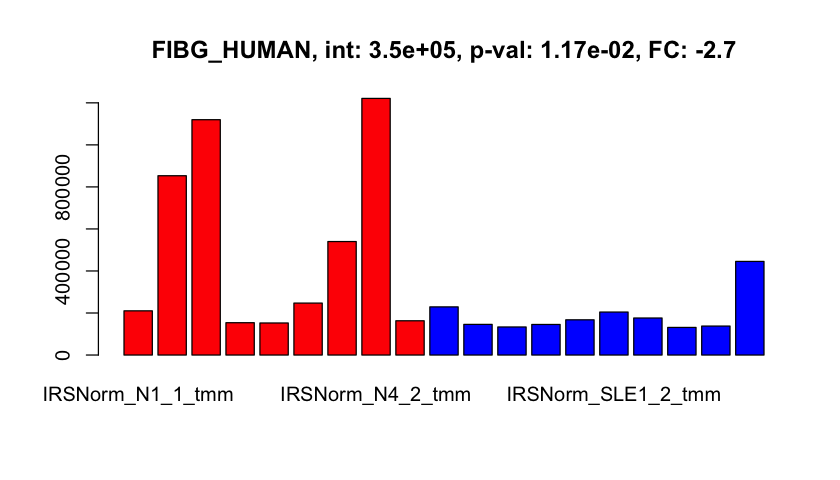

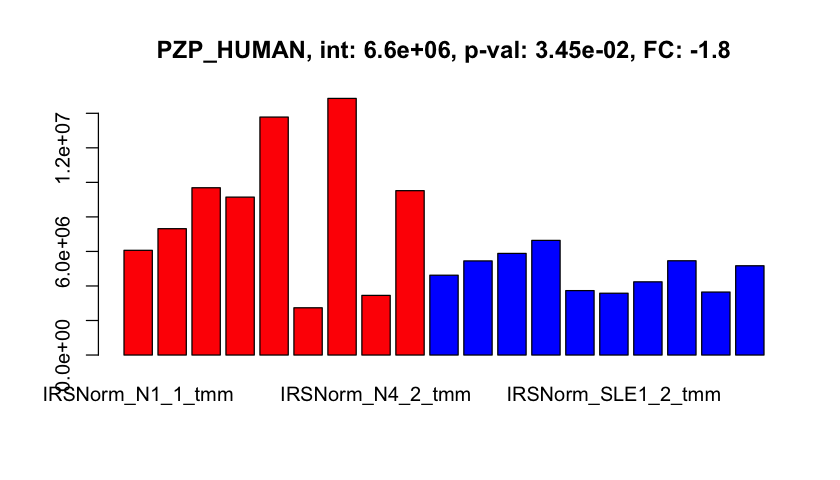

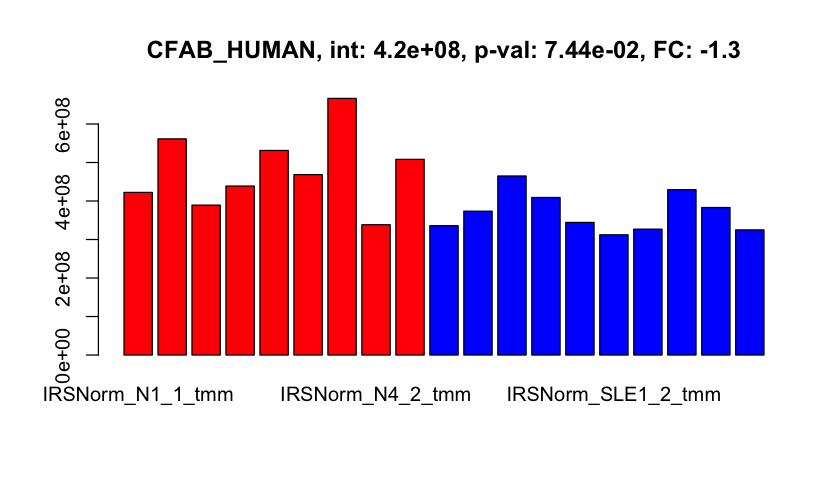

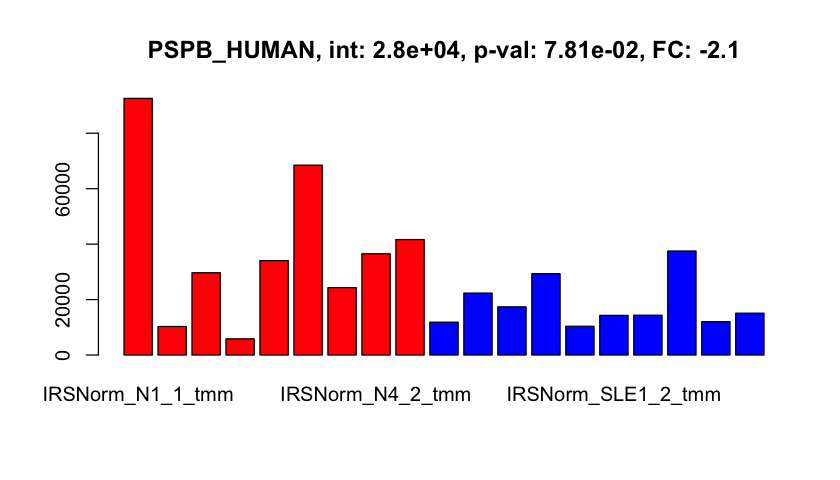

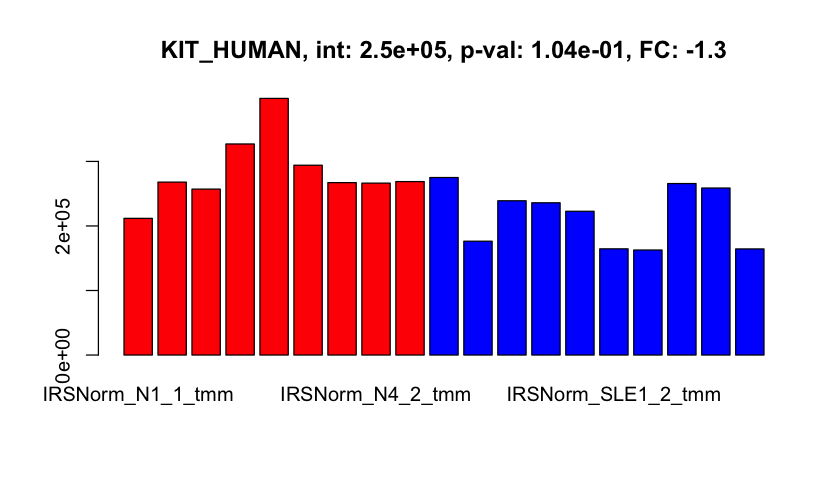

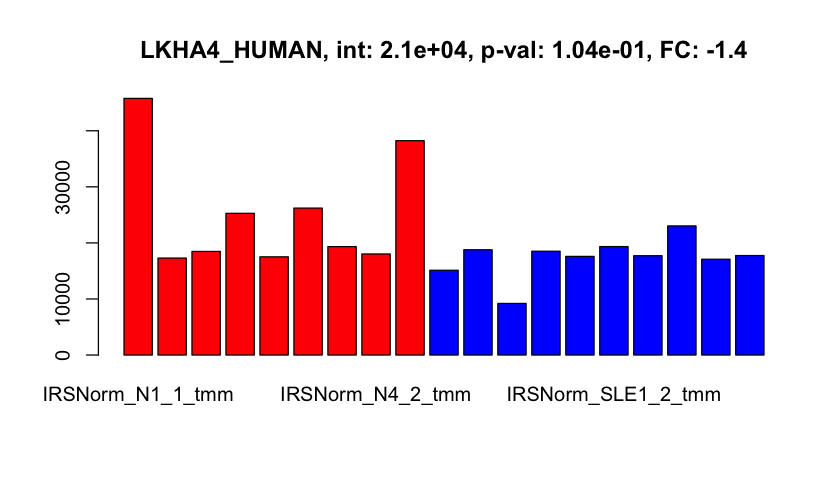

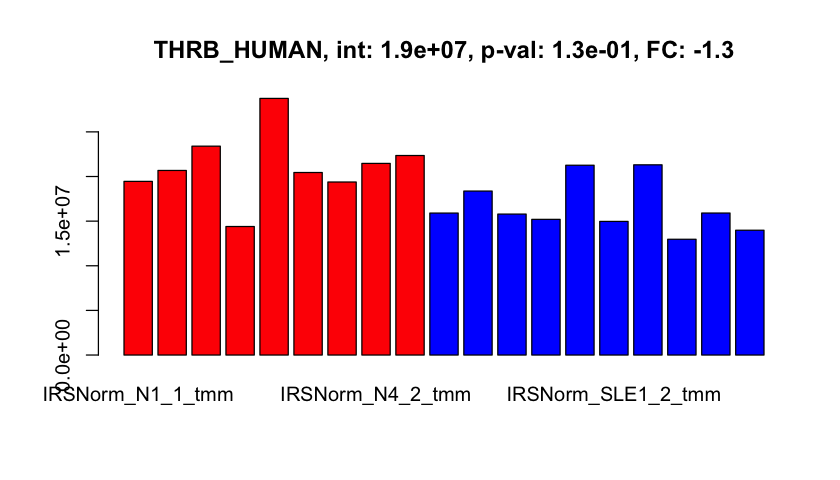

In [22]:
# ============== individual protein expression plots ===========================

# function to extract the identifier part of the accesssion
get_identifier <- function(accession) {
    identifier <- str_split(accession, "\\|", simplify = TRUE)
    identifier[,3]
}

set_plot_dimensions <- function(width_choice, height_choice) {
    options(repr.plot.width=width_choice, repr.plot.height=height_choice)
}

plot_top_tags <- function(results, nleft, nright, top_tags) {
    # results should have data first, then test results (two condition summary table)
    # nleft, nright are number of data points in each condition
    # top_tags is number of up and number of down top DE candidates to plot
    # get top ipregulated
    up <- results %>% 
        filter(logFC >= 0) %>%
        arrange(FDR)
    up <- up[1:top_tags, ]
    
    # get top down regulated
    down <- results %>% 
        filter(logFC < 0) %>%
        arrange(FDR)
    down <- down[1:top_tags, ]
    
    # pack them into one data frame
    proteins <- rbind(up, down)
        
    color = c(rep("red", nleft), rep("blue", nright))
    for (row_num in 1:nrow(proteins)) {
        row <- proteins[row_num, ]
        vec <- as.vector(unlist(row[1:(nleft + nright)]))
        names(vec) <- colnames(row[1:(nleft + nright)])
        title <- str_c(get_identifier(row$Acc), ", int: ", scientific(mean(vec), 2), 
                       ", p-val: ", scientific(row$FDR, digits = 3), 
                       ", FC: ", round(row$FC, digits = 1))
        barplot(vec, col = color, main = title)
    }    
}

# set plot size, make plots, reset plot size
set_plot_dimensions(7, 4)                      
plot_top_tags(results, length(N), length(SLE), 10)
set_plot_dimensions(width, height)

## What do the DE candidates say about the SLE condition?

I have no idea. I leave that to the biological experts. My goal is to create a framework to generate DE candidates with high confidence and full data transparency. It is clear from the above bar plots that some candidate proteins have more subject-to-subject biological variability than do other candidates. I do not have enough experience (or any at all) with the SLE disease, so I have no idea what characteristics define interesting markers. I do have some confidence that the measurement data has been properly processed and that the results are valid. I feel that I have met my data analysis professional obligation of having done no harm to the data.

---

## Save the `results` frame to TSV file

In [23]:
write.table(results, "IRS_R_ave_results.txt", sep = "\t",
           row.names = FALSE, na =  " ")

## Log the session information

In [24]:
sessionInfo()

R version 3.5.3 (2019-03-11)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS Mojave 10.14.4

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] psych_1.8.12    edgeR_3.24.3    limma_3.38.3    scales_1.0.0   
 [5] forcats_0.4.0   stringr_1.4.0   dplyr_0.8.0.1   purrr_0.3.2    
 [9] readr_1.3.1     tidyr_0.8.3     tibble_2.1.1    ggplot2_3.1.1  
[13] tidyverse_1.2.1

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-3     tidyselect_0.2.5 locfit_1.5-9.1   repr_0.19.2     
 [5] splines_3.5.3    haven_2.1.0      lattice_0.20-38  colorspace_1.4-1
 [9] generics_0.0.2   htmltools_0.3.6  base64enc_0.1-3  rlang_0.3.4     
[13] pi